# Rolling Window Regression
**Gauge Units**: **feet**

**Goals**
- Target column: Predict next gauge level
- Independent variables: 7 gauge levels for each day of that week, either rainfall/discharge average avg or max of that week

### Columns for New DF
- Date of Week (optional)
- Gauge for days 1-7 of that week
- rainfall_ft per week– Max or Mean
- Target: next week's day 1 rainfall
    - using other vars to predict target

### Resources
- [R Article](https://medium.com/making-sense-of-data/time-series-next-value-prediction-using-regression-over-a-rolling-window-228f0acae363)
- [Python Article](https://www.statsmodels.org/dev/examples/notebooks/generated/rolling_ls.html)
- [Rolling OLS Docs](https://www.statsmodels.org/dev/generated/statsmodels.regression.rolling.RollingOLS.html)
- [Rolling OLS RESULTS Docs](https://www.statsmodels.org/dev/generated/statsmodels.regression.rolling.RollingRegressionResults.htmlhttps://www.statsmodels.org/dev/generated/statsmodels.regression.rolling.RollingRegressionResults.html)
- [Stack Overflow](https://stackoverflow.com/questions/68320086/puzzles-with-rolling-windows-for-statsmodels-rollingols)

### Problem
This model gives us coefficients but (seemingly) no predictions!
Next step: Pivot data ourselves into correct format and regress on it with SKLearn

**Procedure**
- Data Manipulation– get the df we need!
- Run all linear regressions, random forest, XGB, polynomial if we have time
- Model evaluation and comparison

In [1]:
# Stats-specific imports
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
from statsmodels.tools import add_constant

In [22]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
pd.plotting.register_matplotlib_converters()

import seaborn as sns # Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt # Visualization
%matplotlib inline
mpl.rcParams['figure.dpi'] = 150

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, r2_score
from sklearn.model_selection import train_test_split

import math

import warnings # Supress warnings 
warnings.filterwarnings('ignore')

from datetime import date

np.random.seed(0)
sns.set_style("darkgrid")

### Load Data

In [3]:
levels = pd.read_csv("Data/Daily_Max_Vals.csv", index_col=0)
levels.head()

,date,stid,gauge,discharge,rainfall_inches,rainfall_ft
0,2007-10-01,RA101,2.40,23.9,0.0,0.0
1,2007-10-02,RA101,2.39,23.2,0.0,0.0
2,2007-10-03,RA101,2.39,23.2,0.0,0.0
3,2007-10-04,RA101,2.39,23.2,0.0,0.0
4,2007-10-05,RA101,2.42,25.2,0.0,0.0


In [4]:
levels.corr()

,gauge,discharge,rainfall_inches,rainfall_ft
gauge,1.000000,0.964503,0.526547,0.519915
discharge,0.964503,1.000000,0.508548,0.502007
rainfall_inches,0.526547,0.508548,1.000000,0.987850
rainfall_ft,0.519915,0.502007,0.987850,1.000000


### Pre-Processing

In [5]:
levels.drop(columns=['discharge', 'rainfall_inches'], inplace=True)
levels.head()

,date,stid,gauge,rainfall_ft
0,2007-10-01,RA101,2.40,0.0
1,2007-10-02,RA101,2.39,0.0
2,2007-10-03,RA101,2.39,0.0
3,2007-10-04,RA101,2.39,0.0
4,2007-10-05,RA101,2.42,0.0


In [6]:
levels['date'] = pd.to_datetime(levels['date'], infer_datetime_format=True)
levels.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5477 entries, 0 to 5476
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         5477 non-null   datetime64[ns]
 1   stid         5477 non-null   object        
 2   gauge        5477 non-null   float64       
 3   rainfall_ft  5477 non-null   float64       
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 213.9+ KB


## Rolling Window Regression
Since discharge is highly correlated with gauge, we'll choose **rainfall_ft** as our secondary predictor variable

In [29]:
target = levels['gauge']

In [30]:
exog = add_constant(levels['rainfall_ft'], prepend=False)

In [31]:
mod = RollingOLS(target, exog)
rolling_res = mod.fit(reset=50)

In [32]:
rolling_params = mod.fit(params_only=True)

In [54]:
mod = RollingOLS(target, exog, window=7, min_nobs=3, expanding=True)
rres = mod.fit()

In [55]:
# params = rres.params.copy()
# params.index = np.arange(1, params.shape[0] + 1)

In [56]:
params = rres.params

In [57]:
params.head()

,rainfall_ft,const
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
4,NaN,NaN


### Model visualization

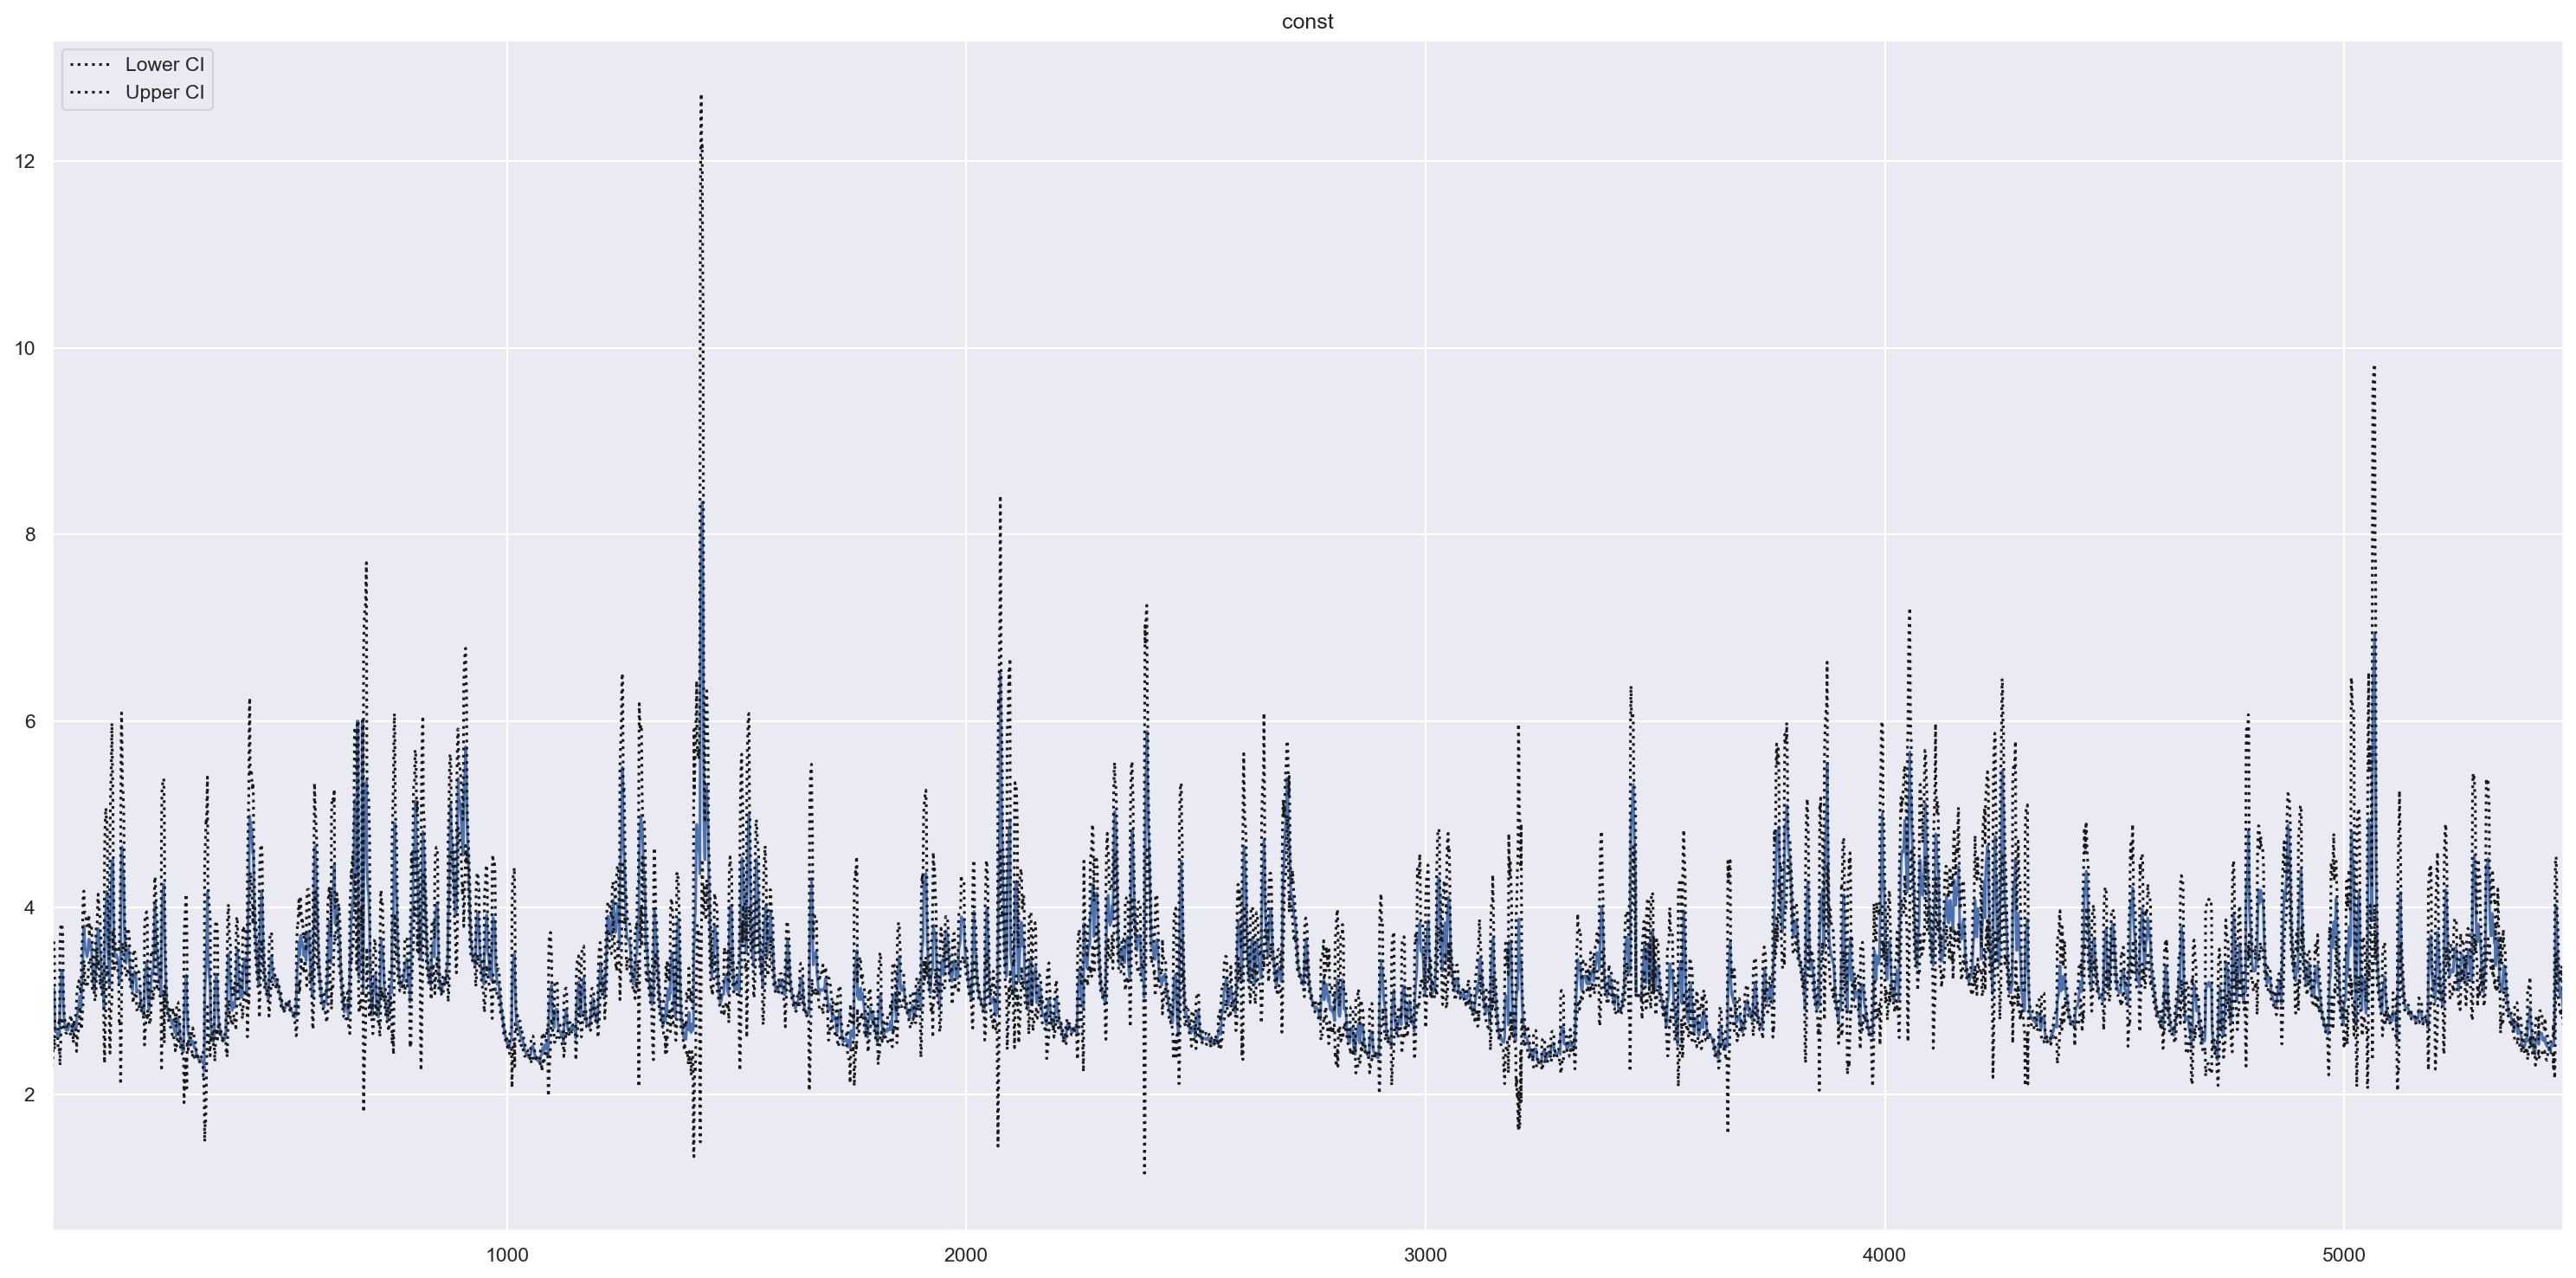

In [68]:
fig = rres.plot_recursive_coefficient(variables=['const'], figsize=(20, 10))

<AxesSubplot:xlabel='date', ylabel='gauge'>

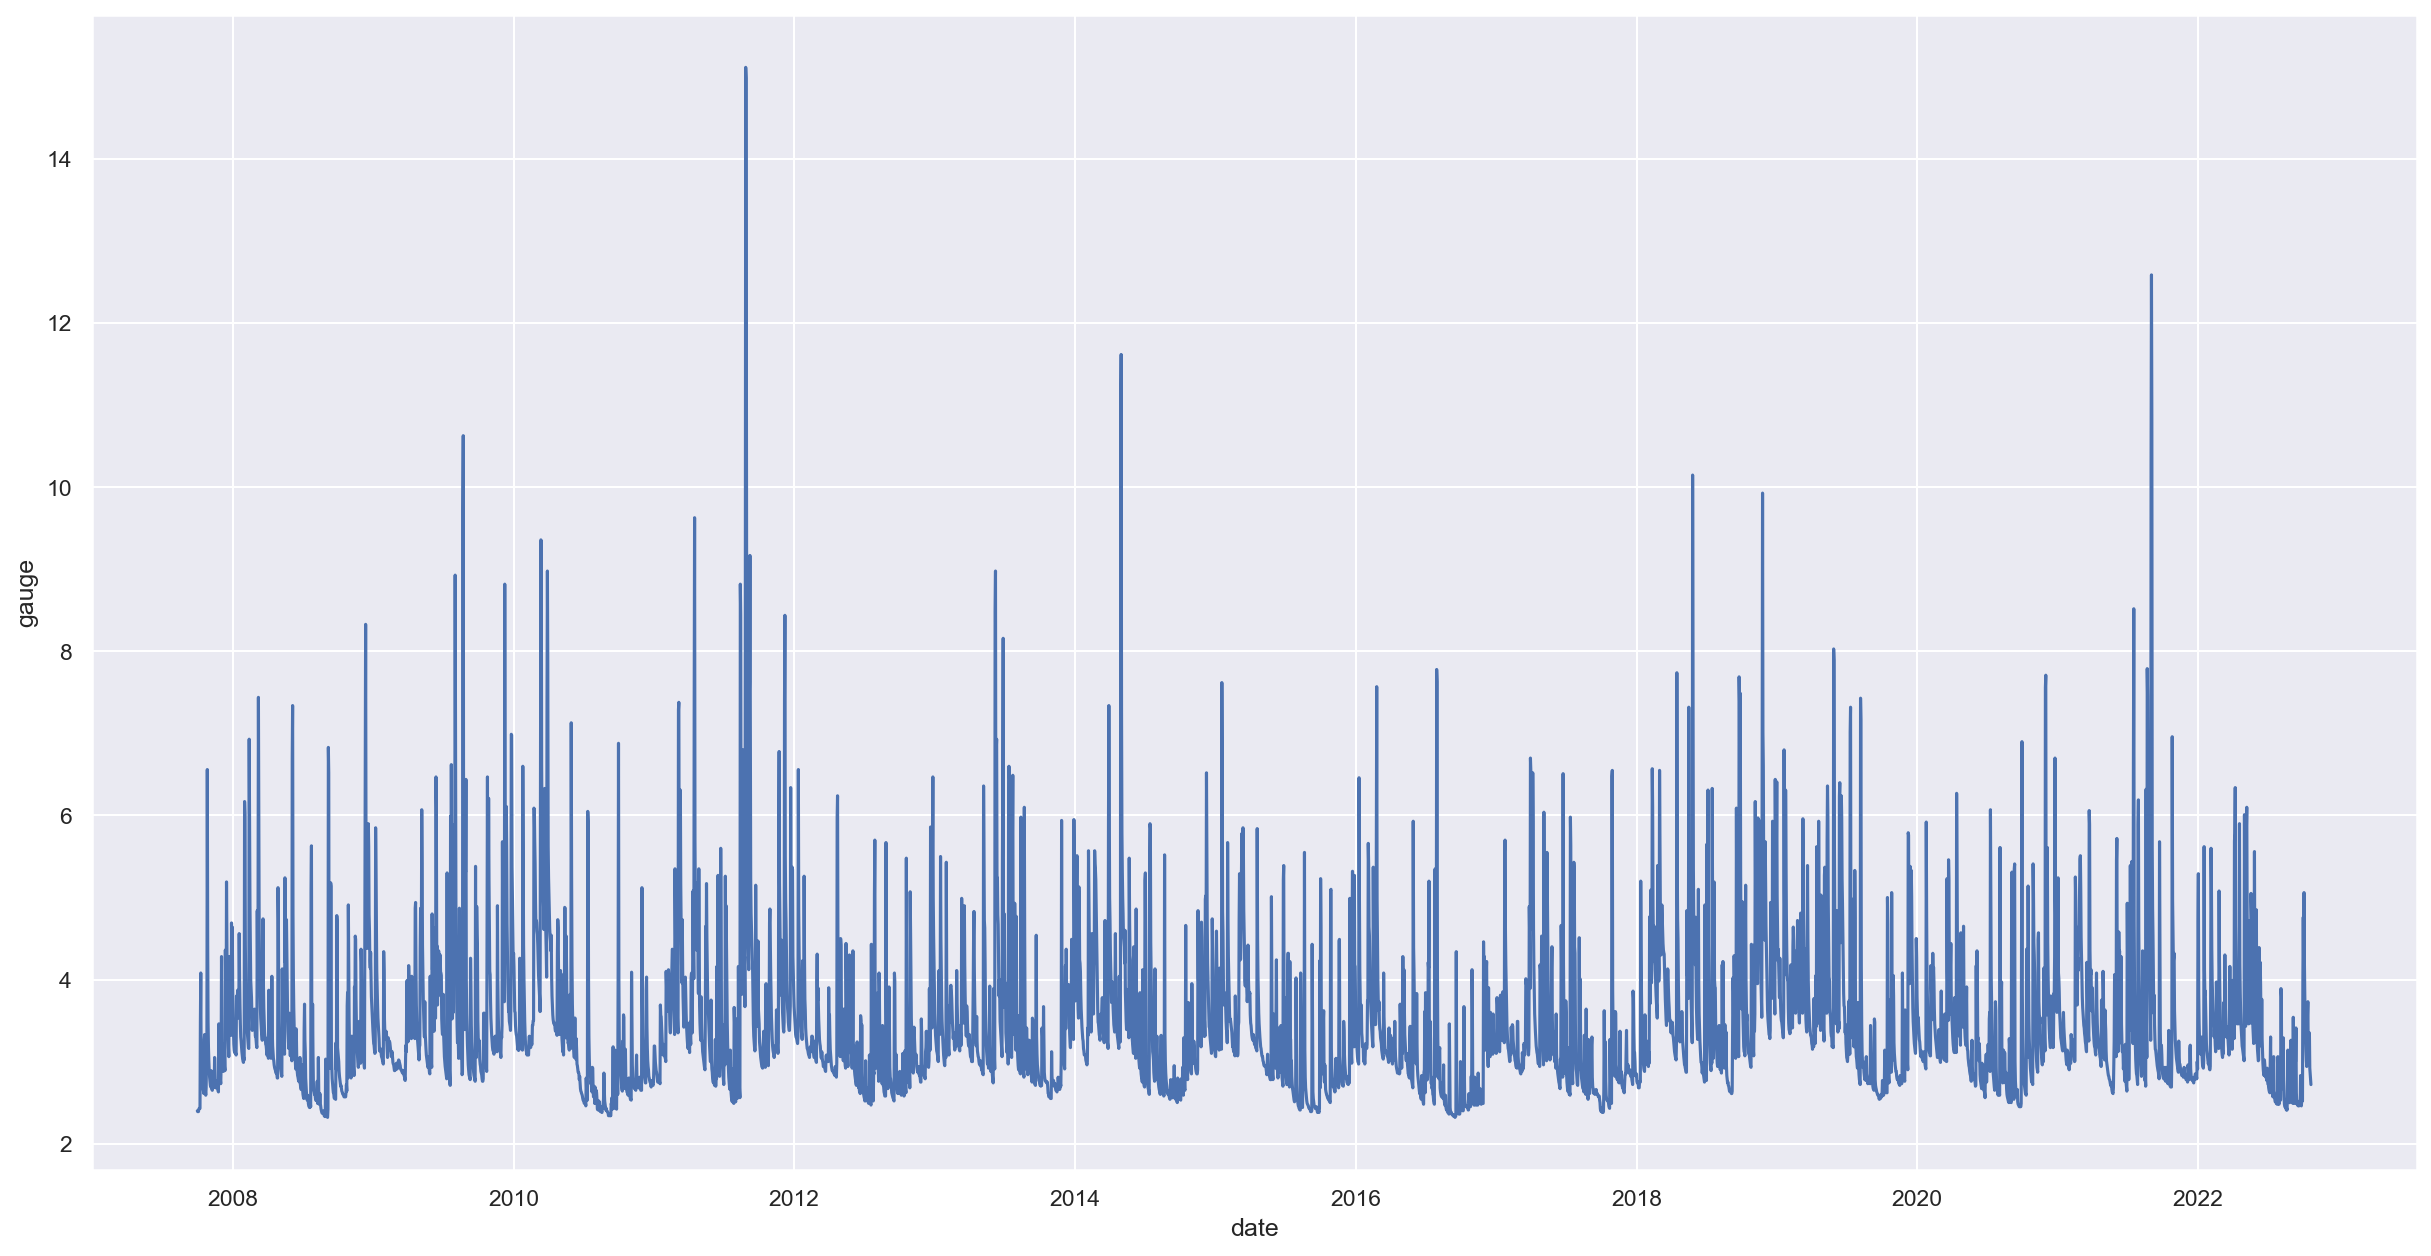

In [64]:
plt.figure(figsize=(20, 10))
sns.lineplot(data=levels, x='date', y='gauge')

In [67]:
rres.mse_model

0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
          ...   
5472    0.222316
5473    0.249096
5474    0.215316
5475    0.111086
5476    0.152402
Length: 5477, dtype: float64